<a href="https://colab.research.google.com/github/kopapatzimos/pneumonia_detection/blob/main/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collect Data/Imports/Create Functions

**KAGGLE API**

In [ ]:
#this code takes the data from competition detect-pneumonia-spring-2022
#saves the data in google colab
#data:test_images/train_images/labels_train.csv
from google.colab import files
!pip install -q kaggle
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle competitions download -c detect-pneumonia-spring-2022
!unzip detect-pneumonia-spring-2022.zip

**IMPORTS**

In [ ]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import cv2
import csv

#tensorflow imports
import tensorflow
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
# read labels_train.csv and save it as labels
labels = pd.read_csv('labels_train.csv')


**FUNCTIONS**

In [ ]:
#functions

def visualize_data(labels):

  #visualize our data
  '''
  Class 0: no disease
  Class 1: bacterial pneumonia
  Class 2: viral pneumonia
  '''
  cases = labels['class_id'].value_counts()
  plt.figure(figsize=(8,6))
  sns.barplot(x=cases.index, y= cases.values)
  plt.title('Number of cases', fontsize=10)
  plt.xlabel('Labels', fontsize=8)
  plt.ylabel('Count', fontsize=8)
  plt.xticks(range(len(cases.index)), ['Normal(0)', 'Bacterial Pneumonia(1)', 'Viral Pneumonia(2)'])
  plt.show()

#-------------------------------------------

def resize_images(dir, image_list, final_dir):
  """
  this functions takes a direction and a list with images
  resizes the image dimensions in 224x224 (height x width)
  returns the  new resized images in final_dir
  """

  for im in image_list:
    # read images
    img = cv2.imread(dir + im, cv2.IMREAD_UNCHANGED)
    #print('Original Dimensions : ',img.shape)

    dim = (224,244)
    resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    #print(final_dir + im)
    cv2.imwrite(final_dir + im,resized_img)
  print('Resizing Completed')
#-------------------------------------------
def plot_dimensions(dir, image_list):
  """
  This function takes a direction, and an image_list as argms and plot the jointplot of their dimensions
  """
  d1 = []
  d2 = []
  for im in image_list:
    # read images
    img = cv2.imread(dir + im, cv2.IMREAD_UNCHANGED)
    #print('Original Dimensions : ',img.shape)
    dim1, dim2, *r = img.shape
    d1.append(dim1)
    d2.append(dim2)
  sns.jointplot(d1,d2)

#-------------------------------------------
def my_vgg16():
  """
  -this function  creates a vgg16 model with our bottom layers
  -returns the model
  """
  model = Sequential()
  #vgg top layers
  model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding='same', activation='relu'))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
  model.add(Flatten(name='flatten'))

  #our bottom layers
  model.add(Dense(1024, activation='relu', name='fc1'))
  model.add(Dense(512, activation='relu', name='fc2'))

  model.add(Dense(3, activation='softmax', name='output'))
  return model


#-------------------------------------------
def plot_loss_curves(history):
  """
  Takes the history of model
  Returns separate loss curves for training and validation metrics.

  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()




#--------------------------------------------------
def create_final_classes(predictions):
  """
  this function takes the predictions, which is an array and transofrms it to integers (0,1,2)
  returns the final_classes
  """
  final_classes = []

  for val in predictions:
    if val[0] == max(val):
      final_classes.append(0)
    elif val[1] == max(val):
      final_classes.append(1)
    elif val[2] == max(val):
      final_classes.append(2)
  return final_classes


#-------------------------------------------------------
def create_csv(final_classes, df_t):
  """
  This function takes as argms: the final classes and the dataframe
  returns a csv with the name of each image and the final class
  """

  final_predictions = []
  filenames= []
  class_id = []

  for i in range(len(final_classes)):
    x = df_t.iloc[i].values.tolist()
    x.append(final_classes[i])
    final_predictions.append(x)
  final_predictions


  for i in final_predictions:
    filenames.append(i[0])
    class_id.append(i[1])


  r = zip(filenames, class_id)
  with open('my_vgg.csv', "w") as my_csv:
      w = csv.writer(my_csv)
      for row in r:
          w.writerow(row)



# Preprocessing

**VISUALIZATIONS**

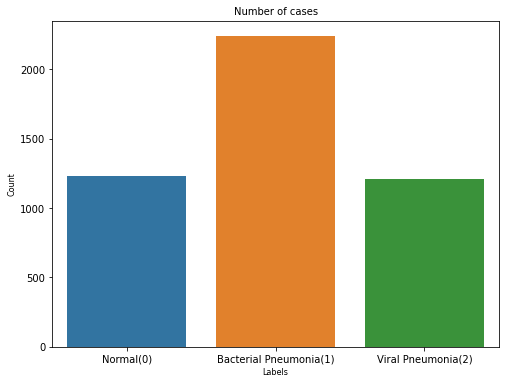

In [ ]:
#visualize data
visualize_data(labels)

In [ ]:
#current direction folders
cur_test_dir = "/content/test_images/"
cur_train_dir = "/content/train_images/"

#final_direction folders
final_test_dir = os.mkdir("/content/test_images_resized/")
final_test_dir = "/content/test_images_resized/"

final_train_dir = os.mkdir("/content/train_images_resized/")
final_train_dir = "/content/train_images_resized/"

In [ ]:
#train_images_list
train_images_list= os.listdir(cur_train_dir)

#test_images_list
test_images_list = os.listdir(cur_test_dir)#list

#print(f'train:{train_images_list}')
#print(f'test:{test_images_list}')




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


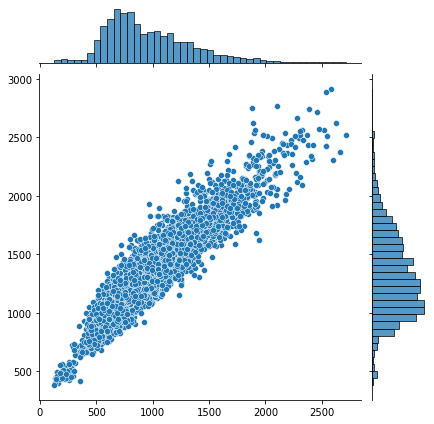

In [ ]:
#plot dimensions of train images
plot_dimensions(dir = cur_train_dir, image_list = train_images_list)

**RESIZE IMAGES**

In [ ]:
#resize train images and saves them in a new folder
resize_images(dir=cur_train_dir, image_list= train_images_list, final_dir = final_train_dir)

#resize test images and saves them in a new folder
resize_images(dir=cur_test_dir, image_list= test_images_list, final_dir = final_test_dir)




Streaming output truncated to the last 5000 lines.
/content/train_images_resized/img_8831938910511375490.jpg
/content/train_images_resized/img_7949980195449247692.jpg
/content/train_images_resized/img_4850044055840688653.jpg
/content/train_images_resized/img_7535479778034373189.jpg
/content/train_images_resized/img_8858240266011873813.jpg
/content/train_images_resized/img_5664821884684186209.jpg
/content/train_images_resized/img_1750178729023209491.jpg
/content/train_images_resized/img_1045521879395944235.jpg
/content/train_images_resized/img_2307658625286244929.jpg
/content/train_images_resized/img_6194389613086415853.jpg
/content/train_images_resized/img_5530061828133861346.jpg
/content/train_images_resized/img_4163834151252950189.jpg
/content/train_images_resized/img_4612645777161605269.jpg
/content/train_images_resized/img_9101471460554341876.jpg
/content/train_images_resized/img_1930143548966404190.jpg
/content/train_images_resized/img_9119115526466019026.jpg
/content/train_images

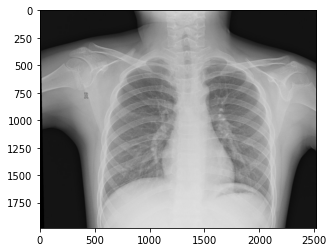

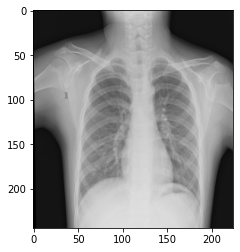

In [ ]:
#read an image fron original train dataset
img = cv2.imread('/content/train_images/img_1004160693662088646.jpg')
plt.imshow(img)

#read the same image from resized train dataset
plt.figure()
img = cv2.imread('/content/train_images_resized/img_1004160693662088646.jpg')
plt.imshow(img)


In [ ]:
#set the final dirs for our project
train_dataset = '/content/train_images_resized'
test_dataset = '/content/test_images_resized'

In [ ]:
#we are goint to use flow_from_dataframes so we have to create:
#1. df_train
#2. df_test
df_train = labels
df_train['class_id'] = df_train['class_id'].astype('str') # requires target in string format
#print(df_train)

df_test = pd.DataFrame(test_images_list)
df_test.columns = ["file_name"]
#print(df_test)

**SET PARAMETERS**

In [ ]:
#values
METRICS = [BinaryAccuracy(name='accuracy')]
CALLBACK = [EarlyStopping(monitor='loss', patience=3)]
BATCH_SIZE = 64
IMG_SIZE = (224,224)
EPOCHS = 35

**DATA AUGMENTATION**

In [ ]:
#create train_datagen
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    validation_split=0.2
    )

#create test_datagen
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
#create train_generator
train_generator_df = train_datagen.flow_from_dataframe(
                                              dataframe=df_train,
                                              directory=train_dataset,
                                              x_col="file_name",
                                              y_col="class_id",
                                              target_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical',
                                              shuffle=True,
                                              subset='training')

#create validation_generator
validation_generator_df = train_datagen.flow_from_dataframe(
                                              dataframe=df_train,
                                              directory=train_dataset,
                                              x_col="file_name",
                                              y_col="class_id",
                                              target_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              class_mode='categorical',
                                              subset='validation')

#create test_generator
test_generator_df=test_datagen.flow_from_dataframe(
                                              dataframe=df_test,
                                              directory=test_dataset,
                                              x_col="file_name",
                                              y_col=None,
                                              target_size = IMG_SIZE,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              class_mode=None)


Found 3738 validated image filenames belonging to 3 classes.
Found 934 validated image filenames belonging to 3 classes.
Found 1168 validated image filenames.


# Create Model

**CREATE**

In [ ]:
#create the model and show the summary
my_vgg = my_vgg16()
#my_vgg.summary()

**COMPILE AND FIT**

In [ ]:
#we compile our model with:
# -> optimizer = Adam
# ->loss = CategoricalCrossentropy
# ->metrics = METRICS
my_vgg.compile(optimizer = Adam(learning_rate=0.0001),
            loss = CategoricalCrossentropy(),
            metrics = METRICS)

In [ ]:
history = my_vgg.fit(
                     train_generator_df,
                     validation_data=validation_generator_df,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     callbacks=CALLBACK)

Epoch 1/35
59/59 [==============================] - 109s 1s/step - loss: 1.0624 - accuracy: 0.6691 - val_loss: 1.0555 - val_accuracy: 0.6667
Epoch 2/35
59/59 [==============================] - 81s 1s/step - loss: 0.9698 - accuracy: 0.7226 - val_loss: 0.9307 - val_accuracy: 0.7470
Epoch 3/35
59/59 [==============================] - 78s 1s/step - loss: 0.9667 - accuracy: 0.7192 - val_loss: 0.9698 - val_accuracy: 0.7263
Epoch 4/35
59/59 [==============================] - 77s 1s/step - loss: 0.8972 - accuracy: 0.7484 - val_loss: 0.8149 - val_accuracy: 0.7744
Epoch 5/35
59/59 [==============================] - 77s 1s/step - loss: 0.8152 - accuracy: 0.7691 - val_loss: 0.8107 - val_accuracy: 0.7684
Epoch 6/35
59/59 [==============================] - 78s 1s/step - loss: 0.7732 - accuracy: 0.7795 - val_loss: 0.7006 - val_accuracy: 0.8076
Epoch 7/35
59/59 [==============================] - 77s 1s/step - loss: 0.6977 - accuracy: 0.8045 - val_loss: 0.6660 - val_accuracy: 0.8141
Epoch 8/35
59/59 [=

**EVALUATE MODEL**

In [ ]:
#evaluate our model in validation_generator_df
my_vgg.evaluate(validation_generator_df)


15/15 [==============================] - 18s 1s/step - loss: 0.4453 - accuracy: 0.8744


**CREATE PREDICTIONS AND PLOT CURVES**

In [ ]:
#make predictions for our model
predictions = my_vgg.predict(test_generator_df)

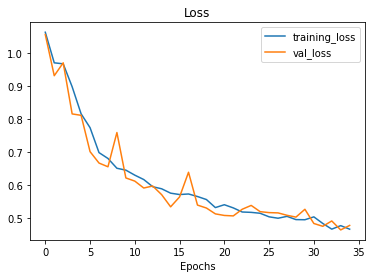

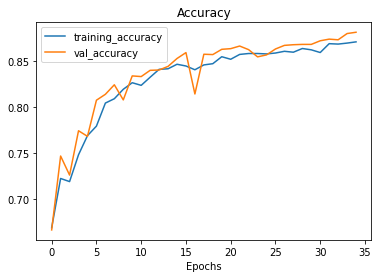

In [ ]:
plot_loss_curves(history)

15/15 [==============================] - 13s 825ms/step - loss: 0.4659 - accuracy: 0.8783


[0.4658958613872528, 0.8783012628555298]

# Create csv with Final Predictions

In [ ]:
final_classes = create_final_classes(predictions)

In [ ]:
create_csv(final_classes, df_test)